# End-to-End Machine Learning Project

## Appendix

1. [Frame the Problem and Look at the Big Picture](#frame-the-problem-and-look-at-the-big-picture)
2. [Get the Data](#get-the-data)
3. [Explore the Data](#explore-the-data)
4. [Prepare the Data](#prepare-the-data)
5. [Shortlist Promising Models](#shortlist-promising-models)
6. [Fine-Tune the System](#fine-tune-the-system)
7. [Present Your Solution](#present-your-solution)
8. [Launch](#launch)

## Frame the Problem and Look at the Big Picture

### Frame the Problem

We have been tasked with using the California census data to build a model of housing prices in the state.

The model should output a district's median housing price. This output will be used as input for a downstream model.

The current solution involves experts manually running complex rules to determine the district's median housing prices. Often they have inaccurate measurements (off by >20%).

We are tasked with predicting a continuous single value using labeled data with multiple features that is not in the form of a stream (live). This means we will be looking at a multiple univariate regression with batch learning.

### Select a Performance Measure

For regression we tend to choose Root Mean Square Error (RMSE) or Mean Absolute Error (MAE) for our performance measure.

Both measure the distance between two vectors. RMSE corresponds to the L2 norm while MAE corresponds to the L1 norm.

The higher the norm index the more it focuses on large values and neglects small ones. Due to this RMSE is more sensitive to outliers than MAE but works better in bell-shaped curve data.

$RMSE(X,h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}$

$MAE(X,h) = \frac{1}{m}\sum_{i=1}^{m}|h(x^{(i)}) - y^{(i)}|$

$h(x^{(i)}) = \hat{y}^{(i)}$

We can begin with RMSE and switch to MAE if we are seeing outliers.

## Get the Data

In [55]:
import os
import tarfile
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Gets most recent housing.tgz from github path and downloads locally to datasets/housing/ and extracts to csv
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    """
    Creates a dataframe from the housing.csv data
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing = load_housing_data()

## Explore the Data

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


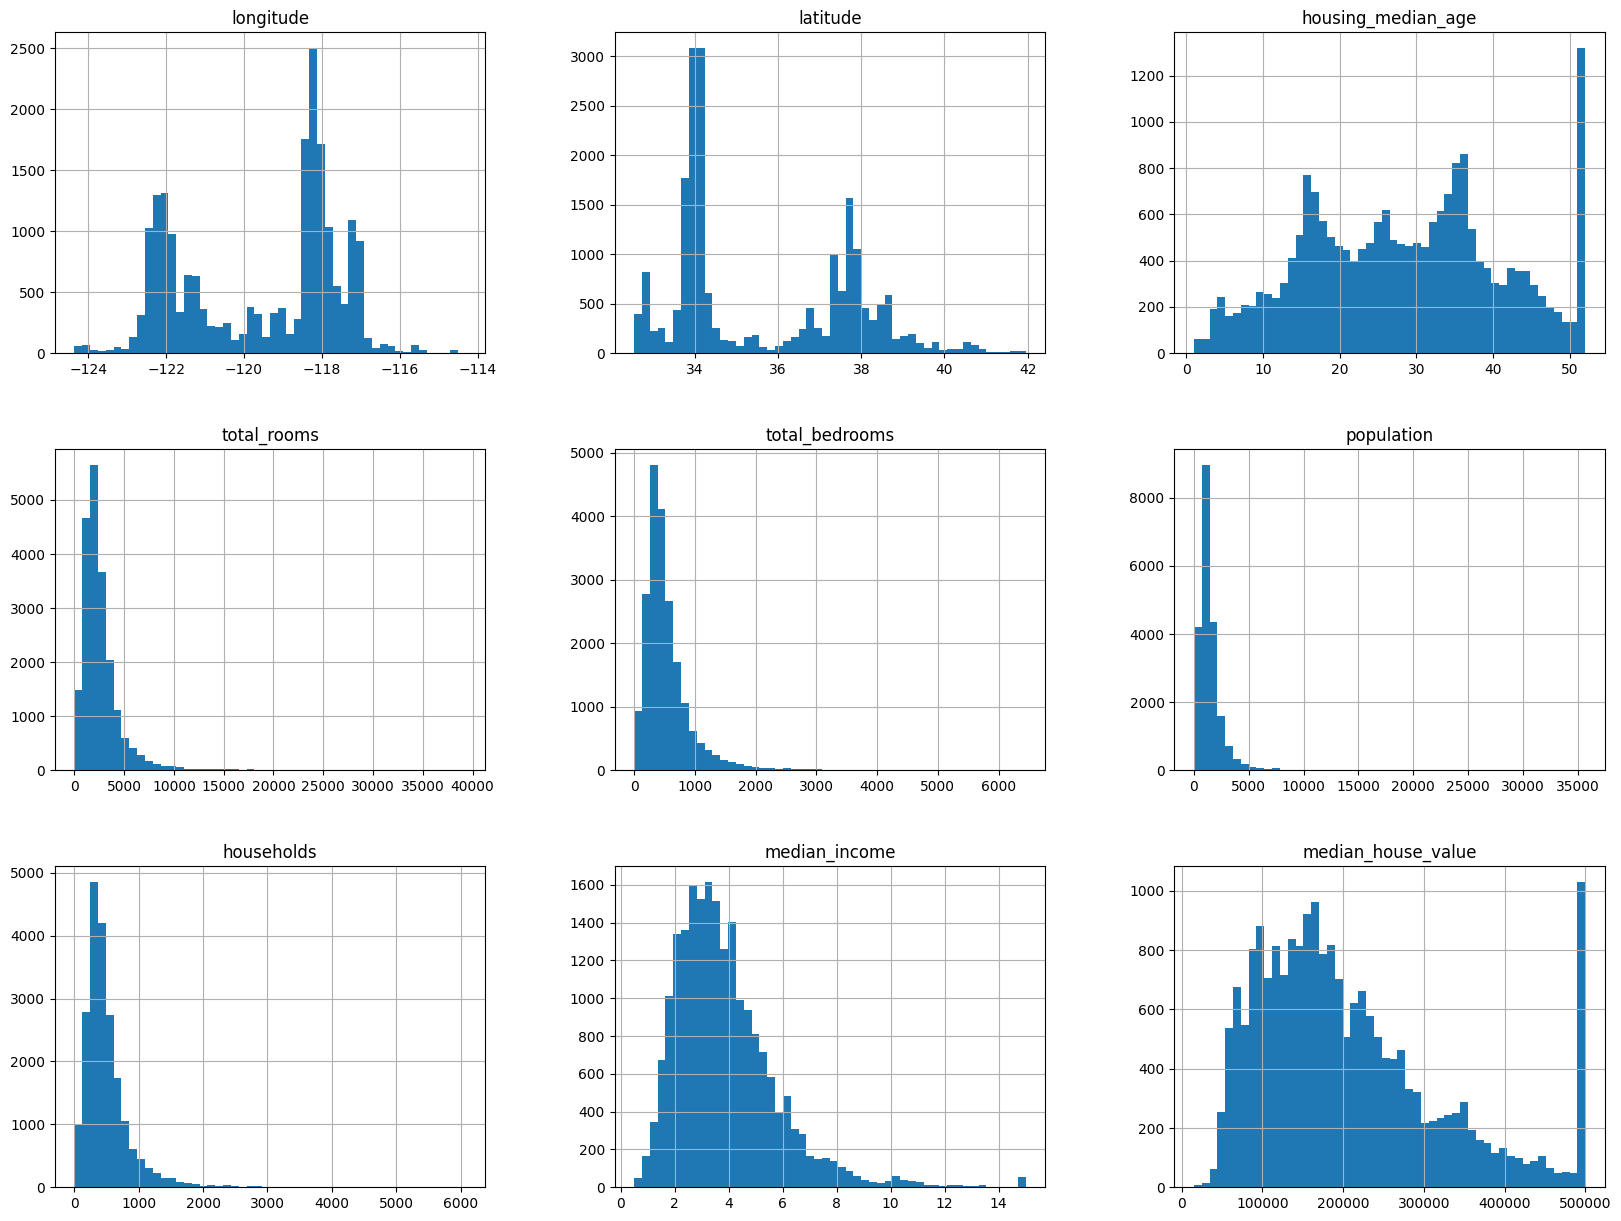

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

* `median_income` - appears to range from 0 to 15 not USD. It turns out this is a scaled income where the numbers are $10,000x. So at 3 this would mean $30,000.

* `housing_median_age` - appears it was capped at 50 we must ensure this is not an issue downstream with the model team ingesting our result.

* `median_house_value` - appears it was capped at $500,000 we must ensure this is not an an issue downstream with the model team ingesting our result.

* Our features have very wide scale differences which will need to be handled in data preparation.

* Some features are showing heavy right skew tailing and will need to be transformed in data preparation.

### Create a Test Set

We are creating a test set early to avoid **data snooping bias**.

Experts informed us that the median income is an extremely important attribute for predicting median housing prices. We want to ensure that the test set is reprsentative of the various cateogires of incomes.

First we will categorize the continuous `median_income` feature and use the new categorical feature to do a stratified shuffling to ensure that there are even amounts in the train and test datasets.

In [11]:
housing['income_cat'] = (pd
    .cut(housing['median_income'],
        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
        labels=[1,2,3,4,5,])
)

<Axes: >

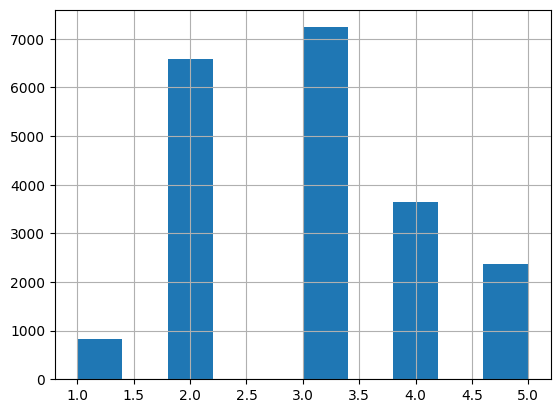

In [12]:
housing['income_cat'].hist()

In [13]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [15]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [16]:
for set_ in [strat_test_set, strat_train_set]:
    set_.drop('income_cat', axis=1, inplace=True)

### Data Exploration

In [17]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

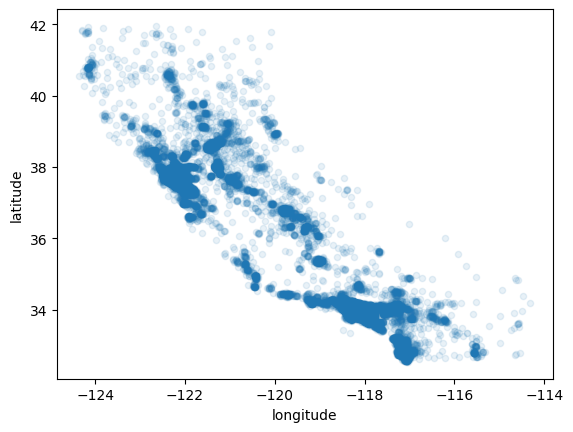

In [18]:
housing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.1
    )

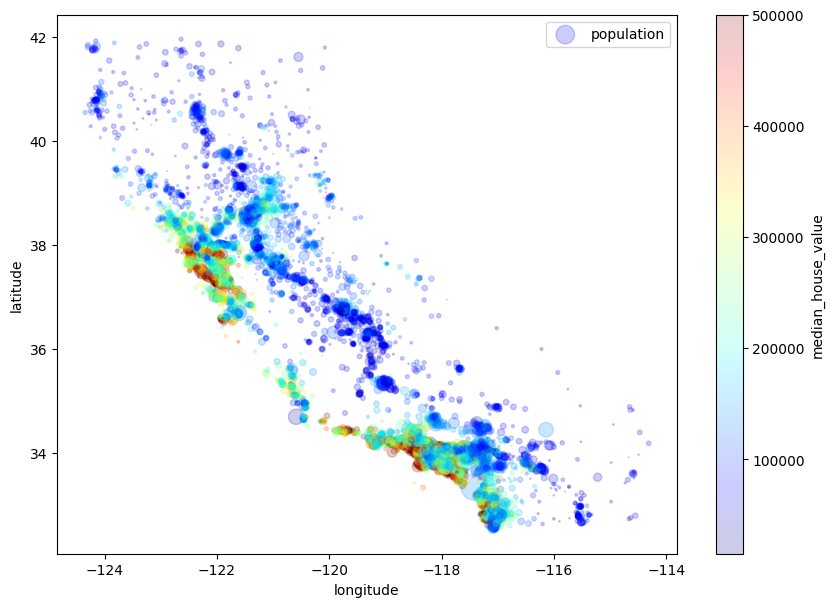

In [19]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.2,
    s=housing['population']/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
)

plt.legend()

### Correlation

In [20]:
housing_corr = housing.drop(columns=['ocean_proximity']) #remove non numericals
housing_corr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0


In [21]:
corr_matrix = housing_corr.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

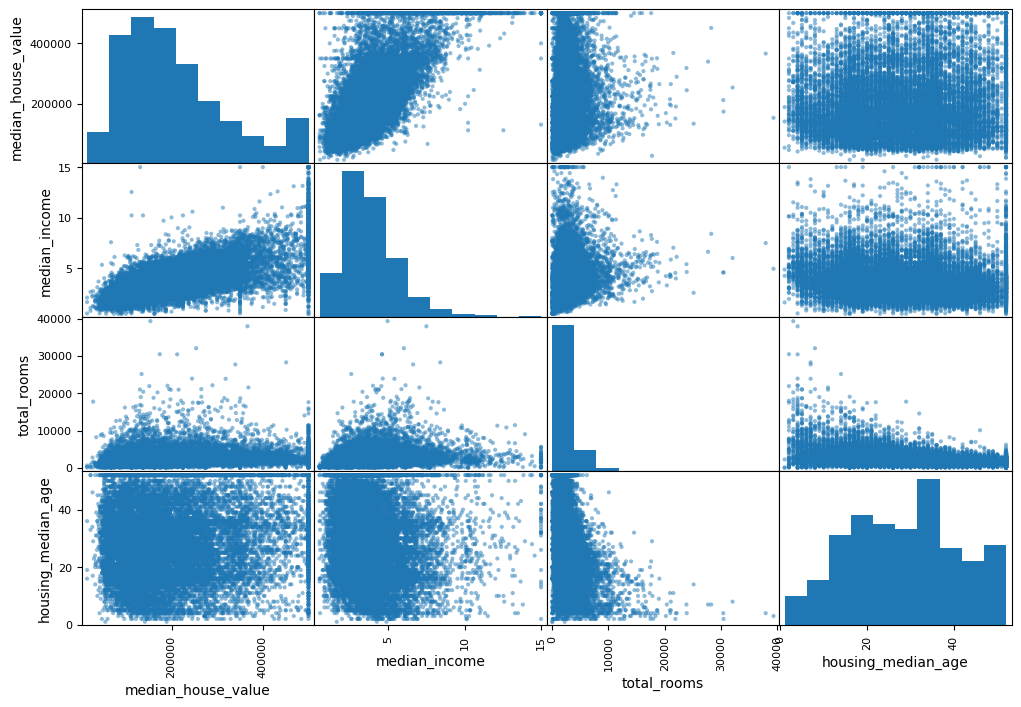

In [22]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

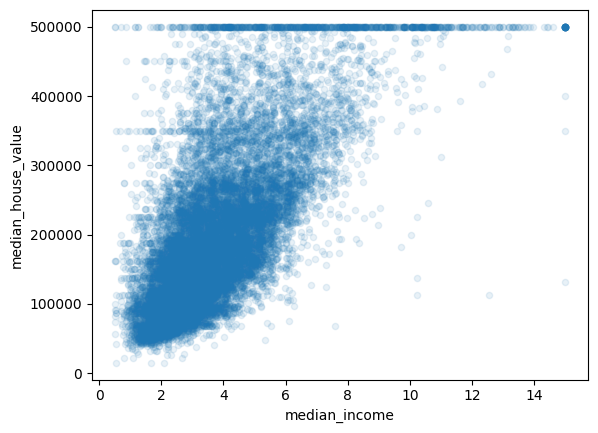

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

We were aware of the 500,000 cap but now you can see lines at ~350,000 and ~450,000 too that are worth investigating.

### Attribute Creation

Now that we have explored the data let's create some new features.

In [24]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [25]:
housing_corr = housing.drop(columns=['ocean_proximity']) # remove non numericals
housing_corr.head()

corr_matrix = housing_corr.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

`bedrooms_per_room` has a pretty good pearson's r value. Houses with less bedrooms/room tend to be more expensive.

Similarly we see that our `rooms_per_household` has a higher correlation than `total_rooms` or `households` on their own.

## Prepare the Data

We want to create a fresh set of data and split out the labels.

All of our cleaning code we will aim to keep in functions as we will need to run the same logic on the live data to make predictions.

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

Remember `total_bedrooms` had missing values. There are 3 main options for handling this

```python
# drop the missing records
housing.dropna(subset=['total_bedrooms']) 

# drop the entire feature
housing.drop('total_bedrooms', axis=1)

# use a summary statistic to fill missing records
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)
```

There are some helpful built in functions for filling missing records with summary statistics.

In [27]:
imputer = SimpleImputer(strategy='median')

# we must drop non numerical columns since median cannot be calculated on categoricals
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [28]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [29]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [30]:
X = imputer.transform(housing_num)

In [31]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [32]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [33]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Categoricals

In [34]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


We want to convert these to numbers so the model can handle the information.

Not just integers but as individual bits per category so the model does not draw comparisons to the integer differences.

**one-hot encoding**

In [39]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Sk learn has many great prebuilt transformers but we will need to make our own transformers for things like data cleaning and feature engineering.

Further, we want our functions to work with the sk learn pipelines so we need to use a class with methods **fit**, **transform**, and **fit_transform**. **fit_transform** can be avoided explicitly by adding base classes such as **TransformerMixin**.



In [48]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [49]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

Machine learning algorithms done perform well when the input numerical attributes have very different scales.

There are 2 main approaches:

* **min-max scaling i.e. normalization** - subtract by the min value, divide by the max minus the min.

* **standardization** - subtract the mean value then divide by the standard deviation.
    * pro: much less affected by outliers
    * con: does not restrict to specific range i.e. [0, 1]

### Transformation Pipelines

In [53]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [54]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

What about handling both the numerical and categoricals together?

In [58]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Shortlist Promising Models

## Fine-Tune the System

## Present Your Solution

## Launch